# 1. Imports and Global Configuration

In [1]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, OrdinalEncoder

from xgboost import XGBClassifier

from beaverfe import auto_feature_pipeline, BeaverPipeline

# Suppress warnings and set Seaborn style
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

# Path to dataset directory
DATASET_DIR = "datasets"

# 2. Dataset Loaders

In [2]:
def load_adult():
    """Load the Adult Income dataset."""
    df = pd.read_csv(os.path.join(DATASET_DIR, "adult.csv"))
    X = df.drop("income", axis=1)
    y = df["income"].apply(lambda x: 1 if ">50K" in str(x) else 0)
    return X, y


def load_bank():
    """Load the Bank Marketing dataset."""
    df = pd.read_csv(os.path.join(DATASET_DIR, "bank.csv"))
    X = df.drop("y", axis=1)
    y = df["y"].apply(lambda x: 1 if x == "yes" else 0)
    return X, y


def load_credit():
    """Load the Credit Default dataset."""
    df = pd.read_csv(os.path.join(DATASET_DIR, "default_of_credit_card_clients.csv"))
    X = df.drop(columns=["default", "ID"])
    y = df["default"]
    return X, y


# Dictionary of dataset loaders
datasets = {
    "adult": load_adult,
    "bank": load_bank,
    "credit": load_credit,
}

# 3. Model Factory

In [3]:
def load_models():
    """Return a dictionary of models to benchmark."""
    return {
        "LDA": LinearDiscriminantAnalysis(),
        "LogisticRegression": LogisticRegression(max_iter=1000),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    }

# 4. Benchmark Function

In [4]:
def run_benchmark():
    """Run baseline vs BeaverFE benchmark on all datasets and models."""
    results = []

    for dataset_name, loader in datasets.items():
        print(f"\n📁 Dataset: {dataset_name.upper()}")
        X, y = loader()

        is_binary = len(np.unique(y)) == 2
        scoring = "roc_auc" if is_binary else "roc_auc_ovr"

        # Identify categorical columns
        cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

        for model_name, model in load_models().items():
            print(f"   🔸 Model: {model_name}")

            # -------- Baseline Pipeline --------
            x_base = X.copy()

            if cat_cols:
                encoder = OrdinalEncoder(
                    handle_unknown="use_encoded_value", unknown_value=-1
                )
                x_encoded = encoder.fit_transform(x_base)
                x_base = pd.DataFrame(
                    x_encoded, columns=x_base.columns, index=x_base.index
                )

            x_train, x_test, y_train, y_test = train_test_split(
                x_base, y, test_size=0.3, random_state=42
            )

            model.fit(x_train, y_train)
            y_score = model.predict_proba(x_test)

            if is_binary:
                baseline_score = roc_auc_score(y_test, y_score[:, 1])
            else:
                y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
                baseline_score = roc_auc_score(
                    y_test_bin, y_score, multi_class="ovr", average="weighted"
                )

            results.append(
                {
                    "dataset": dataset_name,
                    "model": model_name,
                    "pipeline": "baseline",
                    "roc_auc": baseline_score,
                }
            )

            # -------- BeaverFE Pipeline --------
            print("      🧠 Running BeaverFE...")

            x_train_bfe, x_test_bfe, y_train_bfe, y_test_bfe = train_test_split(
                X, y, test_size=0.3, random_state=42
            )

            transformations = auto_feature_pipeline(
                x_train_bfe,
                y_train_bfe,
                model,
                scoring=scoring,
                direction="maximize",
                verbose=False,
            )

            bfe = BeaverPipeline(transformations)
            x_train_bfe = bfe.fit_transform(x_train_bfe, y_train_bfe)
            x_test_bfe = bfe.transform(x_test_bfe, y_test_bfe)

            model.fit(x_train_bfe, y_train_bfe)
            y_score_bfe = model.predict_proba(x_test_bfe)

            if is_binary:
                bfe_score = roc_auc_score(y_test_bfe, y_score_bfe[:, 1])
            else:
                y_test_bin = label_binarize(y_test_bfe, classes=np.unique(y_test_bfe))
                bfe_score = roc_auc_score(
                    y_test_bin, y_score_bfe, multi_class="ovr", average="weighted"
                )

            results.append(
                {
                    "dataset": dataset_name,
                    "model": model_name,
                    "pipeline": "beaverfe",
                    "roc_auc": bfe_score,
                }
            )

    return pd.DataFrame(results)

# 5. Execute Benchmark

In [5]:
print("🏁 Starting full benchmark across datasets and models...")
df_results = run_benchmark()
print("✅ Benchmarking completed.")

🏁 Starting full benchmark across datasets and models...

📁 Dataset: ADULT
   🔸 Model: LDA
      🧠 Running BeaverFE...
   🔸 Model: LogisticRegression
      🧠 Running BeaverFE...
   🔸 Model: XGBoost
      🧠 Running BeaverFE...

📁 Dataset: BANK
   🔸 Model: LDA
      🧠 Running BeaverFE...
   🔸 Model: LogisticRegression
      🧠 Running BeaverFE...
   🔸 Model: XGBoost
      🧠 Running BeaverFE...

📁 Dataset: CREDIT
   🔸 Model: LDA
      🧠 Running BeaverFE...
   🔸 Model: LogisticRegression
      🧠 Running BeaverFE...
   🔸 Model: XGBoost
      🧠 Running BeaverFE...
✅ Benchmarking completed.


# 6. Results Summary Table

In [6]:
# Pivot results for comparison
pivot = df_results.pivot(
    index=["dataset", "model"], columns="pipeline", values="roc_auc"
).reset_index()

# Round and calculate percentage improvement
pivot["baseline"] = pivot["baseline"].round(3)
pivot["beaverfe"] = pivot["beaverfe"].round(3)
pivot["Improvement %"] = (
    100 * (pivot["beaverfe"] - pivot["baseline"]) / pivot["baseline"]
)
pivot["Improvement %"] = pivot["Improvement %"].map(lambda x: f"{x:+.2f}%")

# Rename columns for clarity
pivot = pivot.rename(
    columns={
        "dataset": "Dataset",
        "model": "Model",
        "baseline": "Baseline",
        "beaverfe": "BeaverFE",
    }
)

# Sort and display
pivot = pivot.sort_values(by=["Dataset", "Model"]).reset_index(drop=True)
print(pivot)

pipeline Dataset               Model  Baseline  BeaverFE Improvement %
0          adult                 LDA     0.848     0.905        +6.72%
1          adult  LogisticRegression     0.822     0.903        +9.85%
2          adult             XGBoost     0.921     0.923        +0.22%
3           bank                 LDA     0.874     0.911        +4.23%
4           bank  LogisticRegression     0.854     0.904        +5.85%
5           bank             XGBoost     0.927     0.932        +0.54%
6         credit                 LDA     0.717     0.762        +6.28%
7         credit  LogisticRegression     0.696     0.763        +9.63%
8         credit             XGBoost     0.760     0.761        +0.13%


# 7. ROC AUC Plot

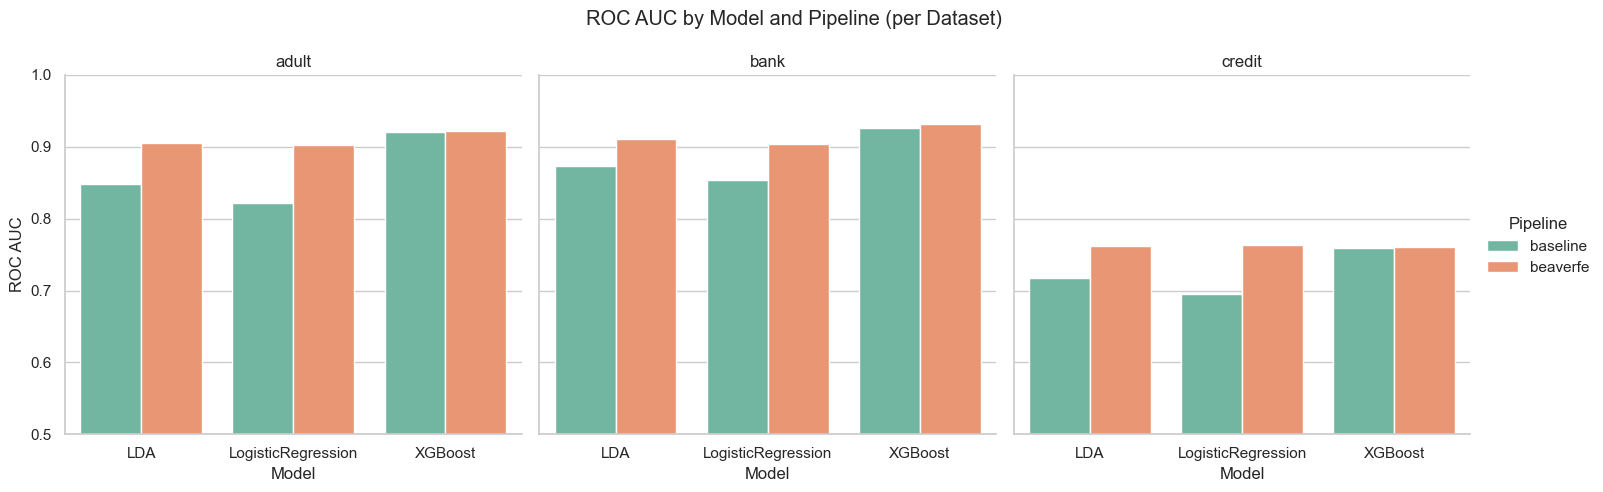

In [7]:
g = sns.catplot(
    data=df_results,
    kind="bar",
    x="model",
    y="roc_auc",
    hue="pipeline",
    col="dataset",
    palette="Set2",
    height=5,
    aspect=1,
)

g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("ROC AUC by Model and Pipeline (per Dataset)")
g.set_axis_labels("Model", "ROC AUC")
g.set_titles(col_template="{col_name}")
g._legend.set_title("Pipeline")

# Set y-axis range for consistency
for ax in g.axes.flat:
    ax.set_ylim(0.5, 1.0)

plt.show()